# Week 3: Introduction to Artificial Neural Networks

In [ ]:
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


## Activation functions
Activation functions are mathematical equations that determine the output of a neural network. The function is attached to each neuron in the network, and determines whether it should be activated (“fired”) or not, based on whether each neuron’s input is relevant for the model’s prediction. Activation functions also help normalize the output of each neuron.

An additional aspect of activation functions is that they must be computationally efficient because they are calculated across thousands or even millions of neurons for each data sample. Modern neural networks use a technique called backpropagation to train the model, which places an increased computational strain on the activation function, and its derivative function.

The popular activation functions and their derivatives are represented:

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

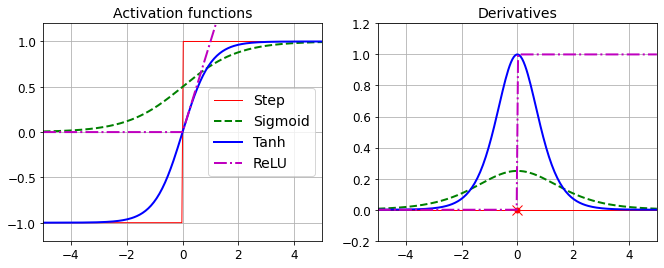

In [ ]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

## NN for MNIST

In this section we will build an MLP with TensorFlow, and we will implement Minibatch Gradient Descent to train it on the MNIST dataset. The first step is the construction phase, building the TensorFlow graph. The second step is the execution phase, where you actually run the graph to train the model.

First we need to import the tensorflow library. Then we must specify the number of inputs and outputs, and set the number of hidden neurons in each layer:

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11501568/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
x_valid, x_train = x_train[:5000], x_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]
print(x_train.shape)

(55000, 784)


# Building a model with Softmax
Softmax extends this idea into a multi-class world. That is, Softmax assigns decimal probabilities to each class in a multi-class problem. Those decimal probabilities must add up to 1.0. This additional constraint helps training converge more quickly than it otherwise would.

For example, returning to the image analysis we saw in Figure 1, Softmax might produce the following likelihoods of an image belonging to a particular class:

![softmax](https://raw.githubusercontent.com/hqsiswiliam/surrey_ai_lab_dataset/master/SoftmaxLayer.svg)

- reference: [Multi-Class Neural Networks: Softmax](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/softmax)


In [ ]:
n_inputs = 28*28  # MNIST
n_hidden1 = 256
n_hidden2 = 128
n_outputs = 10

model = keras.Sequential(
    [
        keras.Input(shape=(28*28,)),
        layers.Dense(n_hidden1, name='hidden1', activation='relu'),
        layers.Dense(n_hidden2, name='hidden2', activation='relu'),
        layers.Dense(n_outputs, activation="softmax")
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 256)               200960    
                                                                 
 hidden2 (Dense)             (None, 128)               32896     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


Now that we have the neural network model ready to go, we need to define the cost function that we will use to train it. We will use cross entropy, cross entropy will penalize models that estimate a low probability for the target class.

In [ ]:
crossentropy = keras.losses.CategoricalCrossentropy()

We have the neural network model, we have the cost function, and now we need to define a GradientDescentOptimizer that will tweak the model parameters to minimize the cost function.

In [ ]:
learning_rate = 0.001
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
accuracy = keras.metrics.CategoricalAccuracy()

And now we can train the model:

In [ ]:
model.compile(loss=crossentropy, optimizer=optimizer, metrics=[accuracy])
model.fit(x_train,y_train,batch_size=128,epochs=10,validation_data=(x_valid,y_valid), shuffle=True)

Epoch 1/10
430/430 [==============================] - 4s 5ms/step - loss: 2.2355 - categorical_accuracy: 0.1849 - val_loss: 2.1125 - val_categorical_accuracy: 0.3682
Epoch 2/10
430/430 [==============================] - 2s 4ms/step - loss: 1.9811 - categorical_accuracy: 0.5182 - val_loss: 1.8497 - val_categorical_accuracy: 0.6086
Epoch 3/10
430/430 [==============================] - 2s 4ms/step - loss: 1.7079 - categorical_accuracy: 0.6622 - val_loss: 1.5635 - val_categorical_accuracy: 0.6920
Epoch 4/10
430/430 [==============================] - 2s 4ms/step - loss: 1.4325 - categorical_accuracy: 0.7225 - val_loss: 1.2986 - val_categorical_accuracy: 0.7446
Epoch 5/10
430/430 [==============================] - 2s 4ms/step - loss: 1.1975 - categorical_accuracy: 0.7651 - val_loss: 1.0896 - val_categorical_accuracy: 0.7850
Epoch 6/10
430/430 [==============================] - 2s 4ms/step - loss: 1.0187 - categorical_accuracy: 0.7939 - val_loss: 0.9358 - val_categorical_accuracy: 0.8096
Epoc

Now that the neural network is trained, you can use it to make predictions. To do that, you can reuse the same construction phase, but change the execution phase like this:

In [ ]:
y_pred = model.predict(x_test)
# Since y_pred only output probabilities over classes, we retrieve the one with max probability
y_pred = np.argmax(y_pred, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)
print("Predicted classes:", y_pred)
print("Actual classes:   ", y_test_argmax)

Predicted classes: [7 2 1 ... 4 5 6]
Actual classes:    [7 2 1 ... 4 5 6]


## <font color='red'> Task1</font>

**Task 1:** Train your own MLP on the MNIST dataset and see if you can get over 95% precision.

**This can be achieved by many ways, here we just replace SGD optmiser by Adam optimiser.**

# Challenge Part: Tumour classification
We have a dataset containing measurements of breast tumours. This is a classification task, unlike last week's which was regression.

- Labels:
  - 'B' for benign (noncancerous) 
  - 'M' for malignant (cancerous)
- Notes:
  - You can use loss related to binary
  - Different activation functions might impact your model
  - You could look at feature-wise normalisation, which may help your model's performance, [using utility functions from scikit-learn](https://scikit-learn.org/stable/modules/preprocessing.html)
  - The Kaggle link is: https://www.kaggle.com/t/3cd15e8c85774fd88ae312a9783db8f1
  - **Please also set your team name to your URN on Kaggle. You may need to return to lab 2's competition page and do this too.**

Set up environment variables for Kaggle (same as in last lab):

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = 'illyagloba'  # Your Kaggle username
os.environ['KAGGLE_KEY'] = 'bfaa0cf3192da654476cf05ceeb4130c'  # Your Kaggle API key
os.environ['URN'] = '6604778'  # Your URN: submissions without a URN will not count

Download the dataset.

Note we invoke Kaggle using `!python`, this means it uses Python 3 and Kaggle 1.5.12. Calling `!kaggle` uses Python 2 and Kaggle 1.5.4. The `kaggle` script defaults to Python 2, hence this difference.

In [ ]:
!kaggle -v
!python2 -m pip show kaggle

Kaggle API 1.5.4
Name: kaggle
Version: 1.5.4
Summary: Kaggle API
Home-page: https://github.com/Kaggle/kaggle-api
Author: Kaggle
Author-email: support@kaggle.com
License: Apache 2.0
Location: /usr/local/lib/python2.7/dist-packages
Requires: requests, tqdm, certifi, python-dateutil, urllib3, six, python-slugify
Required-by: 


In [ ]:
!python3 /usr/local/bin/kaggle -v
!python3 -m pip show kaggle

Kaggle API 1.5.12
Name: kaggle
Version: 1.5.12
Summary: Kaggle API
Home-page: https://github.com/Kaggle/kaggle-api
Author: Kaggle
Author-email: support@kaggle.com
License: Apache 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: python-slugify, six, tqdm, urllib3, requests, python-dateutil, certifi
Required-by: 


In [ ]:
!python3 /usr/local/bin/kaggle competitions download -c uos-com2028-21-22-lab3 --force
!unzip uos-com2028-21-22-lab3.zip

  0% 0.00/46.9k [00:00<?, ?B/s]
100% 46.9k/46.9k [00:00<00:00, 39.0MB/s]
Archive:  uos-com2028-21-22-lab3.zip
  inflating: BreastCancerTest.csv    
  inflating: BreastCancerTrain.csv   


Now to load the dataset:

In [ ]:
import pandas as pd
from tensorflow.keras.utils import to_categorical

train_bc = pd.read_csv('BreastCancerTrain.csv')
test_bc = pd.read_csv('BreastCancerTest.csv')

print(f'Training set sample (target=weight): \n{train_bc[:10]}\n\n')
print(f'Testing set sample (target=weight): \n{test_bc[:3]}\n\n')

# Return all columns that are not the target, 'diagnosis', as a numpy array
X_train_bc = train_bc.loc[:, train_bc.columns != 'diagnosis'].values
X_test_bc = test_bc.loc[:, test_bc.columns != 'id'].values

# Return only the 'diagnosis' column as a numpy array
y_train_bc = train_bc.loc[:, 'diagnosis'].values

# We need to convert the dataset target classes from strings 'M' and 'B' to a 
# boolean indicating 'Is Malignant?'
y_train_bc_bool = y_train_bc == 'M'

# If you want to use one-hot encoding:
y_train_bc_onehot = to_categorical(y_train_bc_bool, 2)

print('Training sample shape', X_train_bc.shape, 'example:', X_train_bc[0])
print('Training target shape one-hot', y_train_bc_onehot.shape, 'example:', y_train_bc_onehot[0])
print('Training target shape bool', y_train_bc_bool.shape, 'example:', y_train_bc_bool[0])
print('Testing sample shape', X_test_bc.shape, 'example:', X_test_bc[0])

Training set sample (target=weight): 
  diagnosis  radius_mean  ...  symmetry_worst  fractal_dimension_worst
0         B       13.270  ...          0.2027                  0.06206
1         B       14.060  ...          0.2523                  0.06609
2         B       10.290  ...          0.2226                  0.08283
3         B        9.738  ...          0.3105                  0.08151
4         B       15.710  ...          0.2723                  0.07071
5         B       11.370  ...          0.3267                  0.06994
6         B       12.560  ...          0.2121                  0.07188
7         B        8.878  ...          0.2434                  0.07431
8         B       14.690  ...          0.2827                  0.09208
9         M       18.220  ...          0.2812                  0.08198

[10 rows x 31 columns]


Testing set sample (target=weight): 
   id  radius_mean  ...  symmetry_worst  fractal_dimension_worst
0   0       15.730  ...          0.2557              

Now build your classifier!

In [ ]:
# Your code here: build your NN classifier
n_inputs = 30  # MNIST
n_hidden1 = 4096
n_hidden2 = 2048
n_hidden3 = 1024
n_hidden4 = 512
n_hidden5 = 256
n_outputs = 2

print(X_train_bc.shape)
model = keras.Sequential(
    [
        keras.Input(shape=(30,)),
        layers.Dense(n_hidden1, name='hidden1', activation='relu'),
        layers.Dense(n_hidden2, name='hidden2', activation='relu'),
        layers.Dense(n_hidden1, name='hidden3', activation='relu'),
        layers.Dense(n_hidden1, name='hidden4', activation='relu'),
        layers.Dense(n_hidden1, name='hidden5', activation='relu'),
        layers.Dense(n_outputs, activation="softmax")
    ]
)

crossentropy = keras.losses.CategoricalCrossentropy()
learning_rate = 0.001
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
accuracy = keras.metrics.CategoricalAccuracy()
precision = keras.metrics.Precision()

model.compile(loss=crossentropy, optimizer=optimizer, metrics=[accuracy, precision])
model.fit(X_train_bc,y_train_bc_onehot,batch_size=128,epochs=450,validation_split=0.2, shuffle=True)

# Set predictions to the output of your model
predictions = model.predict(X_test_bc)

(447, 30)
Epoch 1/450
3/3 [==============================] - 2s 148ms/step - loss: 56.5866 - categorical_accuracy: 0.5686 - precision_1: 0.5686 - val_loss: 22.3037 - val_categorical_accuracy: 0.3556 - val_precision_1: 0.3556
Epoch 2/450
3/3 [==============================] - 0s 33ms/step - loss: 13.1517 - categorical_accuracy: 0.4650 - precision_1: 0.4650 - val_loss: 0.5698 - val_categorical_accuracy: 0.7778 - val_precision_1: 0.7778
Epoch 3/450
3/3 [==============================] - 0s 32ms/step - loss: 2.9799 - categorical_accuracy: 0.5938 - precision_1: 0.5938 - val_loss: 7.1812 - val_categorical_accuracy: 0.3556 - val_precision_1: 0.3556
Epoch 4/450
3/3 [==============================] - 0s 41ms/step - loss: 4.8580 - categorical_accuracy: 0.4482 - precision_1: 0.4482 - val_loss: 0.5446 - val_categorical_accuracy: 0.8111 - val_precision_1: 0.8111
Epoch 5/450
3/3 [==============================] - 0s 28ms/step - loss: 0.6221 - categorical_accuracy: 0.7899 - precision_1: 0.7899 - val_

You will need to convert the output of your model to be 'M' or 'B' for each test sample. This depends on if you used boolean or one-hot encoding for the targets (or probabilities). You may need to adjust the examples below for your model.

In [ ]:
# Uncomment if you used one-hot encoding:
final_predictions = ['M' if prediction == 1 else 'B' for prediction in np.argmax(predictions, axis=1)]

# Uncomment if you boolean encoding:
#final_predictions = ['M' if prediction == 1 else 'B' for prediction in predictions]

Now to save the output to a CSV file:

In [ ]:
pd.DataFrame(data={'Diagnosis': final_predictions}).to_csv('predictions.csv', index_label='Id')

To resubmit, run your model cell (after changes), the CSV file cell and the cell below.

In [ ]:
!python3 /usr/local/bin/kaggle competitions submit -m $URN -c uos-com2028-21-22-lab3 -f predictions.csv

100% 581/581 [00:01<00:00, 418B/s]
Successfully submitted to COM2028 21/22 Lab 3

Your score should soon [show up on Kaggle](https://www.kaggle.com/c/uos-com2028-21-22-lab3/submissions)...